# 02__redundant_enhancers

in this notebook, i find "redundant" enhancers for every element in the MPRA -- i.e. those whose CAGE-seq expression profiles are correlated above a certain threshold with element of interest

In [1]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from random import shuffle
from scipy.stats import linregress
from scipy.stats import spearmanr
from scipy.stats import pearsonr

# import utils
sys.path.append("../../../utils")
from plotting_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

In [4]:
QUANT_ALPHA = 0.05

## functions

In [5]:
def modified_otsu(arr, n_bins, range_min, range_max):
    hist, bins = np.histogram(arr, bins=n_bins, range=(range_min, range_max))
    bins = bins[:-1]
    hist_norm = hist.ravel()/hist.max()
    Q = hist_norm.cumsum()
    fn_min = np.inf
    thresh = -1
    for i in range(1, n_bins):
        p1, p2 = np.hsplit(hist_norm, [i])
        q1, q2 = Q[i], Q[n_bins-1] - Q[i]
        b1, b2 = np.hsplit(bins, [i])
        m1, m2 = np.sum(p1 * b1)/q1, np.sum(p2 * b2)/q2
        v1, v2 = np.sum(((b1 - m1)**2)*p1)/q1, np.sum(((b2 - m2)**2)*p2)/q2

        fn = v1 * q1 + v2 * q2
        if fn < fn_min:
            fn_min = fn
            thresh = i

    cutoff = bins[thresh]
    return cutoff, fn_min

In [6]:
def cis_trans_status(row):
    if row.cis_status_one == "significant cis effect":
        if row.trans_status_one == "significant trans effect":
            if "higher in human" in row.cis_status_det_one:
                if "higher in human" in row.trans_status_det_one:
                    return "cis/trans directional"
                else:
                    return "cis/trans compensatory"
            else:
                if "higher in human" in row.trans_status_det_one:
                    return "cis/trans compensatory"
                else:
                    return "cis/trans directional"
        else:
            return "cis effect only"
    else:
        if row.trans_status_one == "significant trans effect":
            return "trans effect only"
        else:
            return "no cis or trans effects"

## variables

In [7]:
data_f = "../../../data/02__mpra/03__results/all_processed_results.txt"

In [8]:
# directory w/ correlation info
corr_dir = "../../../misc/04__enh_tss_corrs"

In [9]:
hg19_nearby_elems_f = "../../../misc/03__nearby_elems/hg19.all_TSS_and_enh_within_tad.txt"
mm9_nearby_elems_f = "../../../misc/03__nearby_elems/mm9.all_TSS_and_enh_within_tad.txt"

In [10]:
hg19_tads_f = "../../../misc/03__nearby_elems/hg19_evo.tad_assignments.txt"
mm9_tads_f = "../../../misc/03__nearby_elems/mm9_evo.tad_assignments.txt"

## 1. import data

In [11]:
data = pd.read_table(data_f)
#data.head()

In [12]:
# import correlation files
human_chroms = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", 
                "19", "20", "21", "22", "X"]
mouse_chroms = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", 
                "19", "X"]

human_corr_dict = {}
mouse_corr_dict = {}

for chroms, corr_dict, suffix, sp in zip([human_chroms, mouse_chroms], [human_corr_dict, mouse_corr_dict], 
                                         ["hg19", "mm9"], ["human", "mouse"]):
    print("...importing %s files..." % sp)
    for chrom in chroms:
        file = "%s/%s/%s.chr%s.corr.txt" % (corr_dir, sp, suffix, chrom)
        try:
            df = pd.read_table(file)
            df.set_index("Unnamed: 0", inplace=True)
            df.index.name = "Id"
            corr_dict[chrom] = df
        except:
            continue

...importing human files...
...importing mouse files...


In [13]:
hg19_nearby_elems = pd.read_table(hg19_nearby_elems_f, header=None, names=["tss_chr", "tss_start", "tss_end",
                                                                           "name", "score", "tss_strand", "elem_chr",
                                                                           "elem_start", "elem_end", "elem_id", 
                                                                           "elem_score", "elem_strand", "overlap"])

In [14]:
mm9_nearby_elems = pd.read_table(mm9_nearby_elems_f, header=None, names=["tss_chr", "tss_start", "tss_end",
                                                                         "name", "score", "tss_strand", "elem_chr",
                                                                         "elem_start", "elem_end", "elem_id", 
                                                                         "elem_score", "elem_strand", "overlap"])

In [15]:
hg19_tads = pd.read_table(hg19_tads_f, sep="\t", header=None, names=["tss_chr", "tss_start", "tss_end", "name",
                                                                     "score", "tss_strand", "tad_chr", "tad_start",
                                                                     "tad_end", "len", "overlap"])
#hg19_tads.head()

In [16]:
mm9_tads = pd.read_table(mm9_tads_f, sep="\t", header=None, names=["tss_chr", "tss_start", "tss_end", "name",
                                                                     "score", "tss_strand", "tad_chr", "tad_start",
                                                                     "tad_end", "len", "overlap"])
#mm9_tads.head()

## 2. find number of highly correlated regulatory elements w/in the same TAD (defined by Bing Ren's group in hESCs and mESCs) for every element in our dataset

to define "highly correlated" regulatory elements, use Otsu's binarization threshold, which finds the optimal "threshold" in a histogram.

steps:
1. for all elements in MPRA, find all elements that are in the same TAD
2. get a histogram of the correlations of these nearby elements w/ the element of interest in the MPRA
3. use Otsu's binarization method to set a cut-off in the histogram between noise & not-noise
4. count how many elements pass the not-noise cut-off
5. require element to have at least 10 nearby elements to do this analysis (otherwise thresholding is unreliable)

In [17]:
hg19_nearby_elems["hg19_id"] = hg19_nearby_elems["name"].str.split("__", expand=True)[1]
hg19_nearby_elems["tss_tile_num"] = hg19_nearby_elems["name"].str.split("__", 
                                                                    expand=True)[2].str.split(";", expand=True)[0]

In [18]:
mm9_nearby_elems["mm9_id"] = mm9_nearby_elems["name"].str.split("__", expand=True)[1]
mm9_nearby_elems["tss_tile_num"] = mm9_nearby_elems["name"].str.split("__", 
                                                                  expand=True)[2].str.split(";", expand=True)[0]


In [19]:
hg19_nearby_elems_filt = hg19_nearby_elems[["tss_chr", "hg19_id", "tss_tile_num", "elem_id"]].drop_duplicates()
len(hg19_nearby_elems_filt)

962528

In [20]:
# merge w/ MPRA data so we can map ID to cage ID
hg19_nearby_elems_filt = hg19_nearby_elems_filt.merge(data[["hg19_id", "cage_id_hg19"]], 
                                                      on="hg19_id").drop_duplicates()
len(hg19_nearby_elems_filt)

761280

In [21]:
mm9_nearby_elems_filt = mm9_nearby_elems[["tss_chr", "mm9_id", "tss_tile_num", "elem_id"]].drop_duplicates()
len(mm9_nearby_elems_filt)

1038225

In [22]:
# merge w/ MPRA data so we can map ID to cage ID
mm9_nearby_elems_filt = mm9_nearby_elems_filt.merge(data[["mm9_id", "cage_id_mm9"]], 
                                                      on="mm9_id").drop_duplicates()
len(mm9_nearby_elems_filt)

815983

In [23]:
# ONLY LOOK AT ELEMENTS THAT HAVE AT LEAST THE FOLLOWING # OF NEARBY ELEMENTS IN THE SAME TAD
NEARBY_CUTOFF = 10

In [24]:
human_chroms = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", 
                "19", "20", "21", "22", "X"]
mouse_chroms = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", 
                "19", "X"]

hg19_otsu = {}
mm9_otsu = {}

for chroms, otsu, corr_dict, nearby_elems_filt, suffix in zip([human_chroms, mouse_chroms], [hg19_otsu, mm9_otsu],
                                                              [human_corr_dict, mouse_corr_dict], 
                                                              [hg19_nearby_elems_filt, mm9_nearby_elems_filt],
                                                              ["hg19", "mm9"]):
    print("...finding otsu thresh for %s..." % suffix)
    for chrom in chroms:
        corr_df = np.abs(corr_dict[chrom]).reset_index()
        mpra_ids = list(corr_df["Id"])
        if len(corr_df) == 0:
            continue
        
        # find the elements w/in the same TAD as each element in MPRA
        for mpra_id in mpra_ids:
            nearby_ids = list(nearby_elems_filt[nearby_elems_filt["cage_id_%s" % suffix] == mpra_id]["elem_id"])
            nearby_ids = list(set(nearby_ids))
            nearby_ids = [x for x in nearby_ids if x != mpra_id]
            nearby_tss = [x for x in nearby_ids if "," in x]
            nearby_enh = [x for x in nearby_ids if "," not in x]
            
            # limit corr df to IDs of interest
            mpra_id_dict = {}
            for ids, elem_type in zip([nearby_ids, nearby_tss, nearby_enh], ["both", "tss", "enh"]):
                sub_corr_df = corr_df[corr_df["Id"] == mpra_id][ids]
                vals = list(sub_corr_df.iloc[0])
                
                # calculate otsu threshold if there are enough nearby elements
                if len(vals) >= NEARBY_CUTOFF:
                    otsu_thresh, fn_min = modified_otsu(vals, 100, 0, 1)
                    n_ov_otsu = len([x for x in vals if x >= otsu_thresh])
                else:
                    otsu_thresh, fn_min, n_ov_otsu = np.nan, np.nan, np.nan
                
                mpra_id_dict["n_nearby_%s" % elem_type] = len(vals)
                mpra_id_dict["otsu_%s" % elem_type] = otsu_thresh
                mpra_id_dict["n_ov_otsu_%s" % elem_type] = n_ov_otsu
        
            otsu[mpra_id] = mpra_id_dict

...finding otsu thresh for hg19...
...finding otsu thresh for mm9...


In [25]:
hg19_otsu_df = pd.DataFrame.from_dict(hg19_otsu, orient="index").reset_index()
hg19_otsu_df.head()

,index,n_nearby_both,otsu_both,n_ov_otsu_both,n_nearby_tss,otsu_tss,n_ov_otsu_tss,n_nearby_enh,otsu_enh,n_ov_otsu_enh
0,"chr1:101360463..101360478,+",69,0.13,18.0,55,0.13,16.0,14,0.14,1.0
1,"chr1:101360492..101360506,+",69,0.07,14.0,55,0.06,13.0,14,0.03,7.0
2,"chr1:101491313..101491322,-",69,0.16,6.0,55,0.16,6.0,14,0.05,2.0
3,"chr1:101491323..101491355,-",69,0.15,15.0,55,0.15,15.0,14,0.05,6.0
4,"chr1:101491406..101491471,+",69,0.16,17.0,55,0.16,17.0,14,0.05,8.0


In [26]:
mm9_otsu_df = pd.DataFrame.from_dict(mm9_otsu, orient="index").reset_index()
mm9_otsu_df.head()

,index,n_nearby_both,otsu_both,n_ov_otsu_both,n_nearby_tss,otsu_tss,n_ov_otsu_tss,n_nearby_enh,otsu_enh,n_ov_otsu_enh
0,"chr1:107886641..107886666,-",0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
1,"chr1:107886765..107886786,+",0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
2,"chr1:107886820..107886852,-",0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
3,"chr1:107886854..107886873,-",0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
4,"chr1:10983388..10983412,+",41,0.25,7.0,29,0.25,7.0,12,0.07,6.0


## 3. plot some examples of what Otsu binarization actually looks like

do human only for simplicity

total enhancers w/in the same TAD: 250


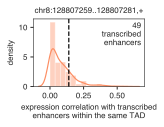

In [27]:
ex_chroms = ["8"]
ids = ["chr8:128807259..128807281,+"]
c = 1

for chrom, idx in zip(ex_chroms, ids):
    corr_df = np.abs(human_corr_dict[chrom]).reset_index()
    nearby_ids = set(list(hg19_nearby_elems_filt[hg19_nearby_elems_filt["cage_id_hg19"] == idx]["elem_id"]))
    nearby_ids = [x for x in nearby_ids if x != idx]
    nearby_enh = [x for x in nearby_ids if "," not in x]
    print("total enhancers w/in the same TAD: %s" % len(nearby_enh))
    sub_corr_df = corr_df[corr_df["Id"] == idx][nearby_enh]
    vals = list(sub_corr_df.iloc[0])
    otsu, fn_min = modified_otsu(vals, 100, 0, 1)
    n_ov = len([x for x in vals if x >= otsu])
    n_un = len([x for x in vals if x < otsu])
    
    # plt
    fig = plt.figure(figsize=(2, 1.25))
    ax = sns.distplot(vals, color=sns.color_palette("Set2")[1], kde=True, bins=15)
    if n_ov == 1:
        text = "1\ntranscribed\nenhancers"
    else:
        text = "%s\ntranscribed\nenhancers" % n_ov
    ax.annotate(text, xy=(0.97, 0.95), xycoords="axes fraction", xytext=(0, 0), 
                textcoords="offset pixels", ha='right', va='top', 
                size=fontsize)
    
    ax.axvline(x=otsu, linestyle="dashed", color="black")
    ax.set_xlabel("expression correlation with transcribed\nenhancers within the same TAD")
    ax.set_ylabel("density")
    ax.set_title(idx)
    plt.show()
    fig.savefig("Fig6H.pdf", dpi="figure", bbox_inches="tight")
    c += 1

## 3. assign cis/trans status

In [28]:
data["cis_trans_status"] = data.apply(cis_trans_status, axis=1)
data.cis_trans_status.value_counts()

no cis or trans effects    1850
cis effect only             741
trans effect only           181
cis/trans directional       101
cis/trans compensatory       79
Name: cis_trans_status, dtype: int64

In [29]:
data = data[~pd.isnull(data["minimal_biotype_hg19"])]
len(data)

2952

In [30]:
data_filt = data[((data["HUES64_padj_hg19"] < QUANT_ALPHA) | (data["mESC_padj_mm9"] < QUANT_ALPHA))]
len(data_filt)

1655

In [31]:
data_filt_sp = data_filt.drop("orig_species", axis=1)
data_filt_sp.drop_duplicates(inplace=True)
len(data_filt_sp)

1644

## 4. merge cis/trans status with redundant enhancer info

In [32]:
data_filt_sp = data_filt_sp.merge(hg19_otsu_df, left_on="cage_id_hg19", right_on="index", how="left")
data_filt_sp = data_filt_sp.merge(mm9_otsu_df, left_on="cage_id_mm9", right_on="index", how="left",
                                  suffixes=("_hg19", "_mm9"))

In [33]:
data_filt_sp["mean_n_nearby_enh"] = data_filt_sp[["n_nearby_enh_hg19", "n_nearby_enh_mm9"]].mean(axis=1)
data_filt_sp["mean_n_ov_otsu_enh"] = data_filt_sp[["n_ov_otsu_enh_hg19", "n_ov_otsu_enh_mm9"]].mean(axis=1)

In [34]:
data_filt_sp.sample(5)

,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cage_id_hg19,name_peak_hg19,minimal_biotype_hg19,stem_exp_hg19,mm9_id,chr_tss_mm9,...,otsu_both_mm9,n_ov_otsu_both_mm9,n_nearby_tss_mm9,otsu_tss_mm9,n_ov_otsu_tss_mm9,n_nearby_enh_mm9,otsu_enh_mm9,n_ov_otsu_enh_mm9,mean_n_nearby_enh,mean_n_ov_otsu_enh
1531,h.2088,chr4,79567370.0,intergenic,"chr4:79567362..79567380,+",ENSG00000251442.1,lncRNA,0.04,m.1900,chr5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0,10.0
1077,h.2823,chr16,85045385.0,no cage activity,no cage activity,no cage activity,lncRNA,no cage activity,m.2634,chr8,...,0.13,83.0,191.0,0.13,64.0,78.0,0.14,17.0,78.0,17.0
1521,h.1971,chr1,145096535.0,intergenic,"chr1:145096530..145096546,+",ENSG00000223380.3,mRNA,7.02222,m.1783,chr3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0,11.0
315,h.682,chr1,29213683.0,protein_coding,"chr1:29213678..29213694,+",ENSG00000159023.14,mRNA,0.281111,m.568,chr4,...,0.20,15.0,31.0,0.19,13.0,11.0,0.20,2.0,11.0,2.0
1209,h.3154,chr11,47586836.0,no cage activity,no cage activity,no cage activity,mRNA,no cage activity,m.2965,chr2,...,0.17,69.0,235.0,0.17,65.0,38.0,0.12,8.0,38.0,8.0


## 5. how many elements within the same TAD, broken up by cis/trans status?

In [35]:
order = ["no cis or trans effects", "cis/trans compensatory", "cis effect only", "trans effect only",
         "cis/trans directional"]
min_order = ["cis/trans compensatory", "cis/trans directional"]
pal = {"no cis or trans effects": sns.color_palette("Set2")[7], "cis effect only": sns.color_palette("Set2")[2],
       "trans effect only": sns.color_palette("Set2")[2], "cis/trans directional": sns.color_palette("Set2")[2],
       "cis/trans compensatory": sns.color_palette("Set2")[7]}

In [36]:
df = data_filt_sp

cis/trans compensatory median: 20.0
cis/trans directional median: 34.0


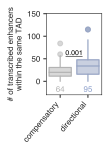

In [37]:
cols = ["mean_n_nearby_enh"]
ylabels = [ "# of transcribed enhancers\nwithin the same TAD"]
ylims = [(-30, 150)]
yps = [55]
plots = ["enh"]

for col, ylabel, ylim, yp, plot in zip(cols, ylabels, ylims, yps, plots):
    fig = plt.figure(figsize=(1, 1.5))
    
    ax = sns.boxplot(data=df, x="cis_trans_status", y=col, order=min_order, 
                 flierprops = dict(marker='o', markersize=5), palette=pal)
    mimic_r_boxplot(ax)

    ax.set_xticklabels(["compensatory", "directional"], rotation=50, ha='right', va='top')
    ax.set_xlabel("")
    ax.set_ylabel(ylabel)

    for i, l in enumerate(min_order):
        sub = df[df["cis_trans_status"] == l]
        n = len(sub)
        print("%s median: %s" % (l, sub[col].median()))
        color = pal[l]
        ax.annotate(str(n), xy=(i, ylim[0]+3), xycoords="data", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=color, size=fontsize)

    ### pvals ###
    vals1 = np.asarray(df[df["cis_trans_status"] == "cis/trans compensatory"][col])
    vals2 = np.asarray(df[df["cis_trans_status"] == "cis/trans directional"][col])

    vals1 = vals1[~np.isnan(vals1)]
    vals2 = vals2[~np.isnan(vals2)]

    _, pval12 = stats.mannwhitneyu(vals1, vals2, alternative="two-sided", use_continuity=False)

    annotate_pval(ax, 0.2, 0.8, yp, 0, yp, pval12, fontsize-1)

    ax.set_ylim(ylim)
    plt.show()

## 6. how many elements w/in the same TAD, broken up by cis/trans status *and* conservation?

In [38]:
def cage_status(row):
    if "CAGE turnover" in row.biotype_switch_minimal:
        return "turnover"
    else:
        return "conserved"

In [39]:
df["cage_status"] = df.apply(cage_status, axis=1)
df["tmp"] = df["cage_status"] + "__" + df["cis_trans_status"]
df.tmp.value_counts()

conserved__no cis or trans effects    731
conserved__cis effect only            399
conserved__trans effect only          123
turnover__no cis or trans effects     119
turnover__cis effect only             102
conserved__cis/trans directional       65
conserved__cis/trans compensatory      56
turnover__cis/trans directional        30
turnover__trans effect only            11
turnover__cis/trans compensatory        8
Name: tmp, dtype: int64

In [40]:
order_cons = ["turnover__cis/trans compensatory", "turnover__cis/trans directional",
              "conserved__cis/trans compensatory", "conserved__cis/trans directional"]
xlabels_cons = ["compensatory", "directional", "compensatory", "directional"]
pal_cons = {"turnover__cis/trans compensatory": sns.color_palette("Set2")[7],
            "turnover__cis/trans directional": sns.color_palette("Set2")[2],
            "conserved__cis/trans compensatory": sns.color_palette("Set2")[7],
            "conserved__cis/trans directional": sns.color_palette("Set2")[2]}

turnover__cis/trans compensatory median: 42.0
turnover__cis/trans directional median: 29.0
conserved__cis/trans compensatory median: 18.25
conserved__cis/trans directional median: 34.5


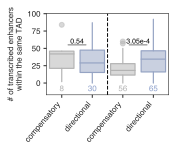

In [41]:
ylims_sep = [(-17, 100)]
yps_sep_a = [55]
yps_sep_b = [55]

for col, ylabel, ylim, yp_a, yp_b, plot in zip(cols, ylabels, ylims_sep, yps_sep_a, yps_sep_b, plots):

    fig = plt.figure(figsize=(2.2, 1.5))
    ax = sns.boxplot(data=df, x="tmp", y=col, order=order_cons, 
                     flierprops = dict(marker='o', markersize=5), palette=pal_cons)
    mimic_r_boxplot(ax)

    ax.set_xticklabels(xlabels_cons, rotation=50, ha='right', va='top')
    ax.set_xlabel("")
    ax.set_ylabel(ylabel)
    ax.set_ylim(ylim)
    ax.axvline(x=1.5, linestyle="dashed", linewidth=1, color="black")

    for i, l in enumerate(order_cons):
        sub = df[df["tmp"] == l]
        n = len(sub)
        print("%s median: %s" % (l, sub[col].median()))
        color = pal_cons[l]
        ax.annotate(str(n), xy=(i, ylim[0]+3), xycoords="data", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=color, size=fontsize)

    ### pvals ###
    vals1 = np.asarray(df[df["tmp"] == "turnover__cis/trans compensatory"][col])
    vals2 = np.asarray(df[df["tmp"] == "turnover__cis/trans directional"][col])
    vals3 = np.asarray(df[df["tmp"] == "conserved__cis/trans compensatory"][col])
    vals4 = np.asarray(df[df["tmp"] == "conserved__cis/trans directional"][col])

    vals1 = vals1[~np.isnan(vals1)]
    vals2 = vals2[~np.isnan(vals2)]
    vals3 = vals3[~np.isnan(vals3)]
    vals4 = vals4[~np.isnan(vals4)]

    _, pval12 = stats.mannwhitneyu(vals1, vals2, alternative="two-sided", use_continuity=False)
    _, pval34 = stats.mannwhitneyu(vals3, vals4, alternative="two-sided", use_continuity=False)

    annotate_pval(ax, 0.2, 0.8, yp_a, 0, yp_a, pval12, fontsize-1)
    annotate_pval(ax, 2.2, 2.8, yp_b, 0, yp_b, pval34, fontsize-1)
    
    plt.show()
    fig.savefig("Fig6G.pdf", dpi="figure", bbox_inches="tight")

## 6. how many redundant elements, broken up by cis/trans status?

how many "highly" correlated regulatory elements (both enhancers + TSSs), TSSs only, and enhancers only are there within the same TAD on average for elements that show either compensatory or directional cis/trans effects?

cis/trans compensatory median: 7.0
cis/trans directional median: 7.5


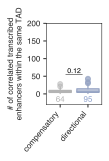

In [42]:
cols = ["mean_n_ov_otsu_enh"]
ylabels = ["# of correlated transcribed\nenhancers within the same TAD"]
ylims = [(-30, 200), (-30, 200), (-10, 50)]
yps = [55, 50, 18]
plots = ["both", "TSS", "enh"]

for col, ylabel, ylim, yp, plot in zip(cols, ylabels, ylims, yps, plots):
    fig = plt.figure(figsize=(1, 1.5))
    
    ax = sns.boxplot(data=df, x="cis_trans_status", y=col, order=min_order, 
                 flierprops = dict(marker='o', markersize=5), palette=pal)
    mimic_r_boxplot(ax)

    ax.set_xticklabels(["compensatory", "directional"], rotation=50, ha='right', va='top')
    ax.set_xlabel("")
    ax.set_ylabel(ylabel)

    for i, l in enumerate(min_order):
        sub = df[df["cis_trans_status"] == l]
        n = len(sub)
        print("%s median: %s" % (l, sub[col].median()))
        color = pal[l]
        ax.annotate(str(n), xy=(i, ylim[0]+3), xycoords="data", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=color, size=fontsize)

    ### pvals ###
    vals1 = np.asarray(df[df["cis_trans_status"] == "cis/trans compensatory"][col])
    vals2 = np.asarray(df[df["cis_trans_status"] == "cis/trans directional"][col])

    vals1 = vals1[~np.isnan(vals1)]
    vals2 = vals2[~np.isnan(vals2)]

    _, pval12 = stats.mannwhitneyu(vals1, vals2, alternative="two-sided", use_continuity=False)

    annotate_pval(ax, 0.2, 0.8, yp, 0, yp, pval12, fontsize-1)

    ax.set_ylim(ylim)
    plt.show()

trend's there but weak; what happens if we subset by conservation pattern and ask the same question? 

turnover__cis/trans compensatory median: 10.0
turnover__cis/trans directional median: 6.0
conserved__cis/trans compensatory median: 7.0
conserved__cis/trans directional median: 11.0


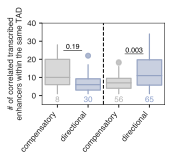

In [43]:
ylims_sep = [(-5, 40)]
yps_sep_a = [25]
yps_sep_b = [23]

for col, ylabel, ylim, yp_a, yp_b, plot in zip(cols, ylabels, ylims_sep, yps_sep_a, yps_sep_b, plots):

    fig = plt.figure(figsize=(2.2, 1.5))
    ax = sns.boxplot(data=df, x="tmp", y=col, order=order_cons, 
                     flierprops = dict(marker='o', markersize=5), palette=pal_cons)
    mimic_r_boxplot(ax)

    ax.set_xticklabels(xlabels_cons, rotation=50, ha='right', va='top')
    ax.set_xlabel("")
    ax.set_ylabel(ylabel)
    ax.set_ylim(ylim)
    ax.axvline(x=1.5, linestyle="dashed", linewidth=1, color="black")

    for i, l in enumerate(order_cons):
        sub = df[df["tmp"] == l]
        n = len(sub)
        print("%s median: %s" % (l, sub[col].median()))
        color = pal_cons[l]
        if "enh" in col:
            y = ylim[0] + 0.5
        else:
            y = ylim[0] + 3
        ax.annotate(str(n), xy=(i, y), xycoords="data", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=color, size=fontsize)

    ### pvals ###
    vals1 = np.asarray(df[df["tmp"] == "turnover__cis/trans compensatory"][col])
    vals2 = np.asarray(df[df["tmp"] == "turnover__cis/trans directional"][col])
    vals3 = np.asarray(df[df["tmp"] == "conserved__cis/trans compensatory"][col])
    vals4 = np.asarray(df[df["tmp"] == "conserved__cis/trans directional"][col])

    vals1 = vals1[~np.isnan(vals1)]
    vals2 = vals2[~np.isnan(vals2)]
    vals3 = vals3[~np.isnan(vals3)]
    vals4 = vals4[~np.isnan(vals4)]

    _, pval12 = stats.mannwhitneyu(vals1, vals2, alternative="two-sided", use_continuity=False)
    _, pval34 = stats.mannwhitneyu(vals3, vals4, alternative="two-sided", use_continuity=False)

    annotate_pval(ax, 0.2, 0.8, yp_a, 0, yp_a, pval12, fontsize-1)
    annotate_pval(ax, 2.2, 2.8, yp_b, 0, yp_b, pval34, fontsize-1)
    
    plt.show()
    fig.savefig("Fig6I.pdf", dpi="figure", bbox_inches="tight")

cool! as expected, the trend we see is limited to *conserved* regulatory elements (i.e., those that have CAGE peak in both human and mouse). if there is a directional trend at a conserved element, it is associated w/ higher numbers of redundant elements within the same TAD. this is not true at non-conserved elements, which in general are just noisy and likely acquire directional effects but there is no strong selection to stabilize their activity.

In [44]:
def one_biotype(row):
    if row.minimal_biotype_hg19 == "no CAGE activity":
        return row.minimal_biotype_mm9
    elif row.biotype_switch_minimal == "biotype switch":
        return "biotype switch"
    else:
        return row.minimal_biotype_hg19

In [45]:
df["one_biotype"] = df.apply(one_biotype, axis=1)
df.one_biotype.value_counts()

mRNA              523
lncRNA            471
eRNA              268
biotype switch    215
other             167
Name: one_biotype, dtype: int64

In [46]:
df_cons = df[df["cage_status"] == "conserved"]

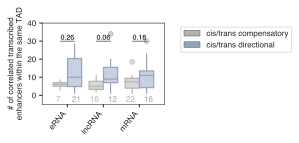

In [47]:
ylims = [(-5, 40)]
yps = [30]
for col, ylabel, ylim, yp, plot in zip(cols, ylabels, ylims_sep, yps, plots):

    fig = plt.figure(figsize=(2.2, 1.5))
    ax = sns.boxplot(data=df_cons, x="one_biotype", y=col, order=["eRNA", "lncRNA", "mRNA"], hue="cis_trans_status",
                     hue_order=["cis/trans compensatory", "cis/trans directional"],
                     flierprops = dict(marker='o', markersize=5), palette=pal)
    mimic_r_boxplot(ax)

    ax.set_xticklabels(["eRNA", "lncRNA", "mRNA"], rotation=50, ha='right', va='top')
    ax.set_xlabel("")
    ax.set_ylabel(ylabel)
    ax.set_ylim(ylim)
    #ax.axvline(x=1.5, linestyle="dashed", linewidth=1, color="black")

    for i, l in enumerate(["eRNA", "lncRNA", "mRNA"]):
        sub = df_cons[df_cons["one_biotype"] == l]
        sub1 = sub[sub["cis_trans_status"] == "cis/trans compensatory"]
        sub2 = sub[sub["cis_trans_status"] == "cis/trans directional"]
        n1 = len(sub1)
        n2 = len(sub2)
        if "enh" in col:
            y = ylim[0] + 0.5
        else:
            y = ylim[0] + 3
        ax.annotate(str(n1), xy=(i-0.25, y), xycoords="data", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=sns.color_palette("Set2")[7], size=fontsize)
        ax.annotate(str(n2), xy=(i+0.25, y), xycoords="data", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=sns.color_palette("Set2")[2], size=fontsize)
        
        ## pvals ##
        vals1 = np.asarray(sub1[col])
        vals2 = np.asarray(sub2[col])
        vals1 = vals1[~np.isnan(vals1)]
        vals2 = vals2[~np.isnan(vals2)]
        _, pval12 = stats.mannwhitneyu(vals1, vals2, alternative="two-sided", use_continuity=False)
        annotate_pval(ax, i-0.2, i+0.2, yp, 0, yp, pval12, fontsize-1)
    
    plt.legend(loc=2, bbox_to_anchor=(1.1, 1))
    plt.show()
    fig.savefig("FigS14.pdf", dpi="figure", bbox_inches="tight")

## 6. sub-sample within the same TAD

since we have several examples of regulatory elements in the MPRA that are w/in close proximity, which could really bias this analysis, let's try and control for that. so what I did for that is to sub-sample regulatory elements based on their TAD assignment in human & mouse: only sample 1 element from each TAD and then plot. I made 10 plots after sub-sampling, and while it's much noisier (we lose precious data), the trend is still there, I think.

In [48]:
hg19_tads["hg19_id"] = hg19_tads["name"].str.split("__", expand=True)[1]
hg19_tads["tad_id"] = hg19_tads["tad_chr"] + ":" + hg19_tads["tad_start"].astype(str)
#hg19_tads.sample(5)

In [49]:
mm9_tads["mm9_id"] = mm9_tads["name"].str.split("__", expand=True)[1]
mm9_tads["tad_id"] = mm9_tads["tad_chr"] + ":" + mm9_tads["tad_start"].astype(str)
#mm9_tads.sample(5)

In [50]:
data_filt_tad = data_filt_sp.merge(hg19_tads[["hg19_id", "tad_id"]], on="hg19_id", how="left")
data_filt_tad = data_filt_tad.merge(mm9_tads[["mm9_id", "tad_id"]], on="mm9_id", suffixes=("_hg19", "_mm9"), 
                                    how="left")
data_filt_tad.drop_duplicates(inplace=True)
#len(data_filt_tad)

In [51]:
data_filt_tad["tad_id_both"] = data_filt_tad["tad_id_hg19"].astype(str) + "__" + data_filt_tad["tad_id_mm9"].astype(str)
#data_filt_tad.sample(5)

In [52]:
col = "mean_n_ov_otsu_enh"
ylabel = "# of correlated transcribed enhancers\nwithin the same TAD"
ylim = (-8, 40)
yp_a = 15
yp_b = 20

In [53]:
print("sampling from unique TAD IDs 1000 times")

samp_results = {}
for x in range(1000):
    data_shuf = data_filt_tad.sample(frac=1)
    data_shuf_sub = data_shuf[["biotype_switch_minimal", "cis_trans_status", "tad_id_both", "mean_n_ov_otsu_enh"]]
    data_shuf_sub = data_shuf_sub[~pd.isnull(data_shuf_sub["mean_n_ov_otsu_enh"])]
    data_shuf_sub = data_shuf_sub.drop_duplicates(subset=["tad_id_both"])
    
    # calculate median of conserved comp/direc and non-conserved comp/direc
    data_non_cons = data_shuf_sub[data_shuf_sub["biotype_switch_minimal"].str.contains("CAGE turnover")]
    data_cons = data_shuf_sub[data_shuf_sub["biotype_switch_minimal"].isin(["eRNA", "lncRNA", "mRNA"])]
    data_non_cons_comp = data_non_cons[data_non_cons["cis_trans_status"] == "cis/trans compensatory"]
    data_non_cons_direc = data_non_cons[data_non_cons["cis_trans_status"] == "cis/trans directional"]
    data_cons_comp = data_cons[data_cons["cis_trans_status"] == "cis/trans compensatory"]
    data_cons_direc = data_cons[data_cons["cis_trans_status"] == "cis/trans directional"]
    
    # first enhancers
    vals_non_cons_comp = np.asarray(data_non_cons_comp["mean_n_ov_otsu_enh"])
    vals_non_cons_direc = np.asarray(data_non_cons_direc["mean_n_ov_otsu_enh"])
    vals_cons_comp = np.asarray(data_cons_comp["mean_n_ov_otsu_enh"])
    vals_cons_direc = np.asarray(data_cons_direc["mean_n_ov_otsu_enh"])
    
    
    med_non_cons_comp = np.median(vals_non_cons_comp)
    med_non_cons_direc = np.median(vals_non_cons_direc)
    med_cons_comp = np.median(vals_cons_comp)
    med_cons_direc = np.median(vals_cons_direc)
    med_non_cons_diff = med_non_cons_direc - med_non_cons_comp
    med_cons_diff = med_cons_direc - med_cons_comp
    
    
    samp_results[x] = {"med_non_cons_comp": med_non_cons_comp,
                       "med_non_cons_direc": med_non_cons_direc, "med_cons_comp": med_cons_comp, 
                       "med_cons_direc": med_cons_direc, "med_non_cons_diff": med_non_cons_diff, 
                       "med_cons_diff": med_cons_diff}

samp_results = pd.DataFrame.from_dict(samp_results, orient="index")
samp_results.sample(5)

sampling from unique TAD IDs 1000 times


,med_non_cons_comp,med_non_cons_direc,med_cons_comp,med_cons_direc,med_non_cons_diff,med_cons_diff
627,10.0,4.5,6.5,10.0,-5.5,3.5
287,6.0,4.0,5.0,8.5,-2.0,3.5
658,10.0,5.5,6.5,10.0,-4.5,3.5
683,10.0,4.0,7.0,9.0,-6.0,2.0
297,10.0,5.0,6.0,10.0,-5.0,4.0


In [54]:
# calculate the 95% confidence interval for every statistic
print("====== ENHANCERS ======")
samp_results = samp_results.sort_values(by="med_non_cons_comp")
med_non_cons_comp_lb = samp_results["med_non_cons_comp"].iloc[25]
med_non_cons_comp_ub = samp_results["med_non_cons_comp"].iloc[975]
print("non-conserved compensatory 95%% confidence interval: %s - %s" % (med_non_cons_comp_lb, med_non_cons_comp_ub))

samp_results = samp_results.sort_values(by="med_non_cons_direc")
med_non_cons_direc_lb = samp_results["med_non_cons_direc"].iloc[25]
med_non_cons_direc_ub = samp_results["med_non_cons_direc"].iloc[975]
print("non-conserved directional 95%% confidence interval: %s - %s" % (med_non_cons_direc_lb, med_non_cons_direc_ub))

samp_results = samp_results.sort_values(by="med_cons_comp")
med_cons_comp_lb = samp_results["med_cons_comp"].iloc[25]
med_cons_comp_ub = samp_results["med_cons_comp"].iloc[975]
print("conserved compensatory 95%% confidence interval: %s - %s" % (med_cons_comp_lb, med_cons_comp_ub))

samp_results = samp_results.sort_values(by="med_cons_direc")
med_cons_direc_lb = samp_results["med_cons_direc"].iloc[25]
med_cons_direc_ub = samp_results["med_cons_direc"].iloc[975]
print("conserved directional 95%% confidence interval: %s - %s" % (med_cons_direc_lb, med_cons_direc_ub))

print("=======")
print("")

samp_results = samp_results.sort_values(by="med_non_cons_diff")
med_non_cons_diff_lb = samp_results["med_non_cons_diff"].iloc[25]
med_non_cons_diff_ub = samp_results["med_non_cons_diff"].iloc[975]
print("non-conserved median difference 95%% confidence interval: %s - %s" % (med_non_cons_diff_lb, med_non_cons_diff_ub))

samp_results = samp_results.sort_values(by="med_cons_diff")
med_cons_diff_lb = samp_results["med_cons_diff"].iloc[25]
med_cons_diff_ub = samp_results["med_cons_diff"].iloc[975]
print("conserved median difference 95%% confidence interval: %s - %s" % (med_cons_diff_lb, med_cons_diff_ub))

====== ENHANCERS ======
non-conserved compensatory 95% confidence interval: 6.0 - 10.0
non-conserved directional 95% confidence interval: 4.0 - 6.0
conserved compensatory 95% confidence interval: 4.0 - 7.0
conserved directional 95% confidence interval: 6.5 - 12.0

non-conserved median difference 95% confidence interval: -6.0 - 0.0
conserved median difference 95% confidence interval: 0.0 - 6.5


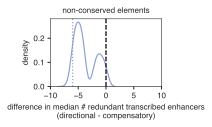

In [55]:
fig = plt.figure(figsize=(2, 1.25))
ax = sns.distplot(samp_results["med_non_cons_diff"], hist=False, color=sns.color_palette("Set2")[2])
ax.axvline(x=med_non_cons_diff_lb, linestyle="dotted", color=sns.color_palette("Set2")[2])
ax.axvline(x=med_non_cons_diff_ub, linestyle="dotted", color=sns.color_palette("Set2")[2])
ax.axvline(x=0, linestyle="dashed", color="black")
ax.set_ylabel("density")
ax.set_xlabel("difference in median # redundant transcribed enhancers\n(directional - compensatory)")
ax.set_title("non-conserved elements")
ax.set_xlim((-10, 10))
fig.savefig("FigS15A.pdf", dpi="figure", bbox_inches="tight")

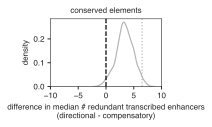

In [56]:
fig = plt.figure(figsize=(2, 1.25))
ax = sns.distplot(samp_results["med_cons_diff"], hist=False, color=sns.color_palette("Set2")[7])
ax.axvline(x=med_cons_diff_lb, linestyle="dotted", color=sns.color_palette("Set2")[7])
ax.axvline(x=med_cons_diff_ub, linestyle="dotted", color=sns.color_palette("Set2")[7])
ax.axvline(x=0, linestyle="dashed", color="black")
ax.set_ylabel("density")
ax.set_xlabel("difference in median # redundant transcribed enhancers\n(directional - compensatory)")
ax.set_title("conserved elements")
ax.set_xlim((-10, 10))
fig.savefig("FigS15B.pdf", dpi="figure", bbox_inches="tight")

the 95% confidence interval of differences b/w # of correlated enhancers trends negative (-6 to 0) meaning that non-conserved elements have higher correlated enhancers for compensatory ones; the 95% confidence interval trends positive (0 to 6.5) for conserved elements, which fits w/ earlier results